# Code setup for Experiments

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
import multiprocessing

from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.inference import * 
from bayes_opt import BayesianOptimization
from lib.parallel import *
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

# Functions to be changed for SF due to changed age groups:
1. lib.data: collect_data_from_df
2. lib.distributions: CovidDistributions

In [10]:
mob_settings = 'lib/mobility/SF_settings_200_100.pk'
#mob_settings = 'lib/tu_settings_20_10.pk'
random_repeats = 1
cpus_used = multiprocessing.cpu_count() 
c = 0 # seed
FIGSIZE = (8, 4)

#### Import town settings

Import downsampled version of Tübingen (population downsampled by 20x, sites by 10x) that was used used to generate mobility traces on the fly for inference (sites, home locations, etc)

In [11]:
# See town-generator.ipynb for an example on how to create own settings
with open(mob_settings, 'rb') as fp:
    obj = pickle.load(fp)
mob = MobilitySimulator(**obj)
np.random.seed(c)
runstr = f'run{c}_'

# General note for plotting: `errorevery` has to be set proportionally to `acc`, and best to keep `acc` as it is

In [12]:
mob.num_people

4236

### Import COVID-19 data

In [4]:
days_until_lockdown = 13 # March 10 - March 23
days_after_lockdown = 20 # March 24 - April 12
days_present = days_until_lockdown + days_after_lockdown + 2 # simulate 2 more days due to test lag
days_future = 12 * 7 # projecting 12 weeks into the future

In [5]:
case_downsample = 100
new_cases_ = collect_data_from_df('LK Tübingen', 'new', until=days_present)
resistant_cases_ = collect_data_from_df('LK Tübingen', 'recovered', until=days_present)
fatality_cases_ = collect_data_from_df('LK Tübingen', 'fatality', until=days_present)

Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr


In [16]:
# fatality rate per age group
num_age_groups = fatality_cases_.shape[1] 
fatality_rates_by_age = (fatality_cases_[-1, :] / \
    (new_cases_[-1, :] + fatality_cases_[-1, :] + resistant_cases_[-1, :]))

# Zihan: adjust the fatality rates to use for SF (for now)
fatality_rates_by_age = np.array([0.0, 0.0, 0.0, 0.0, 0.0005, 0.002, 0.0096, 0.1173])
print('Empirical fatality rates per age group:  ', fatality_rates_by_age.tolist())

Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.0, 0.0005, 0.002, 0.0096, 0.1173]


Scale down cases based on number of people in simulation

In [18]:
new_cases, resistant_cases, fatality_cases = (
    1/case_downsample * new_cases_, 
    1/case_downsample * resistant_cases_, 
    1/case_downsample * fatality_cases_)
new_cases, resistant_cases, fatality_cases = np.ceil(new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)
# The agegroups of new_cases and resistant_cases are inconsistent with mobility for SF. To be ajusted.

Define initial seed count (based on infection counts on March 10)

In [19]:
initial_seeds = {
    'expo' : 1,
    'ipre' : 1,
    'isym' : 3,
    'iasy' : 3,
}
present_seeds = {
    'expo': 3,
    'ipre': 1,
    'iasy': 0,
    'isym_notposi': 8,
    'isym_posi': 4,
    'resi_notposi': 78,
    'resi_posi': 110,
}
max_time_present = 24.0 * (days_present)
max_time_future = 24.0 * (days_future) 


#### Define standard testing parameters, same used for inference

In [20]:
def standard_testing(max_time):
    standard_testing_params = {
        'testing_t_window'    : [0.0, max_time], # in hours
        'testing_frequency'   : 24.0,     # in hours
        'test_reporting_lag'  : 48.0,     # in hours (actual and self-report delay)
        'tests_per_batch'     : 10,       # assume 300 tests/day in LK Tübingen
        'test_smart_delta'    : 24.0 * 3, # in hours
        'test_smart_duration' : 24.0 * 7, # in hours
        'test_smart_action'   : 'isolate', 
        'test_smart_num_contacts'   : 10, 
        'test_targets'        : 'isym',
        'test_queue_policy'   : 'fifo',
        'smart_tracing'       : None, 
    }
    return standard_testing_params

#### Define distributions as estimated by literature 


In [22]:
# instantiate correct distributions
distributions = CovidDistributions(fatality_rates_by_age=fatality_rates_by_age)

#### Set epidemic parameters as inferred using Bayesian optimization

In [23]:
inferred_params = {
    'betas': [1.1383] * 5,  # site infectivity by type
    'alpha': 0.3224,
    'mu': 0.2072
}


Define function to run general type of experiment, fixing the above settings.


In [24]:
def run(tparam, measure_list, t, local_seeds):

    # add standard measure of positives staying isolated
    measure_list +=  [
        SocialDistancingForPositiveMeasure(
            t_window=Interval(0.0, t), p_stay_home=1.0)
    ]
    measure_list = MeasureList(measure_list)

    # run simulations
    summary = launch_parallel_simulations(
        mob_settings, 
        distributions, 
        random_repeats, multiprocessing.cpu_count(), 
        inferred_params, local_seeds, tparam, measure_list, 
        max_time=t, 
        num_people=mob.num_people, 
        num_sites=mob.num_sites, 
        site_loc=mob.site_loc, 
        home_loc=mob.home_loc, verbose=False)
    return summary
    

In [3]:
def save_summary(summary, filename):
    with open('summaries/' + filename, 'wb') as fp:
        pickle.dump(summary, fp)
    
def load_summary(filename):
    with open('summaries/' + filename, 'rb') as fp:
        summary = pickle.load(fp)
    return summary

# Experiments for "A spatiotemporal model for Sars-CoV-2"

## 4.2 Model inference

### 4.2.1 Model projections in uncontrolled scenario until present day (April 13)

In [ ]:
testing_params_opt = standard_testing(max_time_present)
measure_list = []

summary_INF = run(testing_params_opt, measure_list, max_time_present, initial_seeds)

save_summary(summary_INF, 'summary_INF.pk')
summary_INF = load_summary('summary_INF.pk')

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_INF, new_cases.sum(axis=1), 
    test_lag=2,
    title=('Predictions for uncontrolled scenario after March 23'
           'for inferred parameters'), 
    filename=runstr + 'opt_00',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=1000)

In [ ]:
plotter.plot_daily_infected(
    summary_INF,
    title='Infections by type for uncontrolled scenario after March 23', 
    filename=runstr + 'opt_001',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    show_target=new_cases.sum(axis=1),
    ymax=1500)


In [ ]:
plotter.plot_Rt_types(
    summary_INF,
    title='Reproductive rate by contribution for uncontrolled scenario after March 23', 
    filename=runstr + 'opt_002',
    figsize=FIGSIZE,
    errorevery=1, 
    estimation_window=3 * 24.0)

In [ ]:
plt.close()

## 4.3. Social distancing and Business restrictions

### 4.3.1. Reproducing the observed course of Sars-CoV-2 under the taken interventions

In [ ]:
# {0: 'education', 1: 'social', 2: 'bus_stop', 3: 'office', 4: 'supermarket'}
tuned_p_stay_home = 0.2
tuned_site_multipliers = [0.0, 0.0, 0.5, 0.5, 0.5]

observed_measures_SD = [
    # education close, social closes, rest reduced by 50%
    BetaMultiplierMeasureByType(
        t_window=Interval(24.0 * days_until_lockdown, max_time_present), 
        beta_multiplier=tuned_site_multipliers),
    
    # 40 % less activite of all due to contact constraints
    SocialDistancingForAllMeasure(
     t_window=Interval(24.0 * days_until_lockdown, max_time_present), 
        p_stay_home=tuned_p_stay_home)
]

In [ ]:
testing_params_SD_0 = standard_testing(max_time_present)
summary_SD_0 = run(testing_params_SD_0, observed_measures_SD, max_time_present, initial_seeds)

save_summary(summary_SD_0, 'summary_SD_0.pk')
summary_SD_0 = load_summary('summary_SD_0.pk')

In [ ]:
# extract average states at end of simulation
SD_0_expo = summary_SD_0.state['expo'].sum(axis=1).mean()
SD_0_iasy = summary_SD_0.state['iasy'].sum(axis=1).mean()
SD_0_ipre = summary_SD_0.state['ipre'].sum(axis=1).mean()
SD_0_isym = summary_SD_0.state['isym'].sum(axis=1).mean()

ave_present_seeds = {
    'expo' : SD_0_expo,
    'iasy' : SD_0_iasy,
    'ipre' : SD_0_ipre,
    'isym' : SD_0_isym,
}

with open(f'ave_present_seeds_{c}.txt', 'w+') as logfile:
    logfile.write(str(ave_present_seeds) + '\n')

In [ ]:
plotter = Plotter()
plotter.plot_positives_vs_target(
    summary_SD_0, new_cases.sum(axis=1), 
    test_lag=2,
    title='Predictions for observed controlled scenario after March 23', 
    filename=runstr + 'SD_000',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    ymax=150)



In [ ]:
plotter.plot_daily_infected(
    summary_SD_0,
    title='Infections by type for observed controlled scenario after March 23', 
    filename=runstr + 'SD_001',
    figsize=FIGSIZE,
    errorevery=1, acc=500, 
    lockdown_at=days_until_lockdown,
    show_target=new_cases.sum(axis=1),
    ymax=300)



In [ ]:
plotter.plot_Rt_types(
    summary_SD_0,
    title='Reproductive rate by contribution for observed controlled scenario after March 23', 
    filename=runstr + 'SD_002',
    figsize=FIGSIZE,
    errorevery=1, 
    estimation_window=3 * 24.0)

In [ ]:
# TODO: Geomap of change in activity patterns before and after restrictive measures got implemented

# bbox = (48.4900, 48.5485, 9.0224, 9.1061) # coordinate bounding box
# ill = MapIllustrator()
# map_name = 'Map title'
# map_time = 24.0 * 30
# map_summary = summaries_44_1['advanced'][0]
# sitemap = ill.checkin_rate_map(
#     bbox=bbox, site_loc=mob.site_loc, map_name=map_name, 
#     sim=map_summary, t=map_time, r=0)
# sitemap

## Only simulate the future from here onwards 



In [ ]:
# baseline (no measure for the future starting April 12)
future_baseline = run(standard_testing(max_time_future), [], max_time_future, present_seeds) 

### 4.3.2. How long should the current most restrictive measures have to continue, as of April 12?

In [ ]:
# use settings as above and simulate in the future, with additional measures of the same length

continue_for_weeks_SD_2 = [1, 2, 4, 8]
testing_params_SD_2 = standard_testing(max_time_future)
summaries_SD_2 = []

for j, w in enumerate(continue_for_weeks_SD_2):
    
    # same as tuned before but continued for longer
    m = [BetaMultiplierMeasureByType(
            t_window=Interval(0.0, (24.0 * 7 * w)), 
            beta_multiplier=tuned_site_multipliers),

         SocialDistancingForAllMeasure(
         t_window=Interval(0.0, (24.0 * 7 * w)), 
            p_stay_home=tuned_p_stay_home)
    ] 

    res = run(testing_params_SD_2, m, max_time_future, present_seeds) 
    summaries_SD_2.append(res)
    print(w, ' done.')


In [ ]:
save_summary(summaries_SD_2, 'summaries_SD_2.pk')
summaries_SD_2 = load_summary('summaries_SD_2.pk')

In [ ]:
plotter = Plotter()
for j, (w, s) in enumerate(zip(continue_for_weeks_SD_2, summaries_SD_2)):
    
    plotter.plot_daily_infected(
        s,
        title=f'Infections with restrictive measures continued for {w} weeks', 
        filename=runstr + f'SD_01{j}',
        figsize=FIGSIZE,
        errorevery=14, acc=500, 
        lockdown_end=w * 7,
        show_target=new_cases.sum(axis=1),
        ymax=300)

    plotter.plot_Rt_types(
        s,
        title=f'Reproductive rate with restrictive measures continued for {w} weeks', 
        filename=runstr + f'SD_02{j}',
        figsize=FIGSIZE,
        errorevery=14, 
        lockdown_end=w * 7,
        estimation_window=3 * 24.0)

In [ ]:

titles_SD_2 = [f'Restrictions extended by {w} weeks' for w in continue_for_weeks_SD_2]
plotter.compare_total_infections(
    summaries_SD_2, 
    titles=titles_SD_2, 
    figtitle='Total infections for various restriction durations',
    filename=runstr + 'SD_030', 
    figsize=FIGSIZE, acc=500, 
    ymax=300, errorevery=14)

In [ ]:
plt.close()

### 4.3.3. What is the benefit of restricting demographic or random groups?

#### Experiment (i): Businesses and People below 60 years stop restrictive measures after 2 weeks, people above 60 years continue for X more weeks after that

In [ ]:
# use settings as above and simulate in the future, with additional measures of the same length

continue_for_weeks_SD_3 = [0, 4, 8, 12]
testing_params_SD_3 = standard_testing(max_time_future)
summaries_SD_3 = []
cutoff_SD_3 = 2
for j, w in enumerate(continue_for_weeks_SD_3):
    
    # same as tuned before but continued for longer
    m = [BetaMultiplierMeasureByType(
            t_window=Interval(0.0, (24.0 * 7 * cutoff_SD_3)), 
            beta_multiplier=tuned_site_multipliers),

         SocialDistancingForAllMeasure(
         t_window=Interval(0.0, (24.0 * 7 * cutoff_SD_3)), 
            p_stay_home=tuned_p_stay_home),
         
         SocialDistancingByAgeMeasure(
         t_window=Interval((24.0 * 7 * cutoff_SD_3), 
                           (24.0 * 7 * (cutoff_SD_3  + w))), 
         p_stay_home=[0.0, 0.0, 0.0, 0.0, 0.9, 0.9])
    ] 

    res = run(testing_params_SD_3, m, max_time_future, present_seeds) 
    summaries_SD_3.append(res)
    print(w, ' done.')


In [ ]:
save_summary(summaries_SD_3, 'summaries_SD_3.pk')
summaries_SD_3 = load_summary('summaries_SD_3.pk')

In [ ]:
titles_SD_3 = [f'Extended by {w} weeks' for w in continue_for_weeks_SD_3]
plotter.compare_total_fatalities_and_hospitalizations(
    summaries_SD_3, 
    titles=titles_SD_3, 
    figtitle='Hospitalizations and Fatalities when social distancing of ages 60+',
    filename=runstr + 'SD_040', 
    figsize=FIGSIZE,
    acc=500,
    ymax=50, errorevery=14)

plotter.compare_total_infections(
    summaries_SD_3, 
    titles=titles_SD_3, 
    figtitle=r'Total infections when social distancing of ages 60+',
    filename=runstr + 'SD_041', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

Map plot of change in activity patterns

In [ ]:
# bbox = (48.4900, 48.5485, 9.0224, 9.1061) # coordinate bounding box
# ill = MapIllustrator()
# map_name = 'Map title'
# map_time = 24.0 * 30
# map_summary = summaries_44_1['advanced'][0]
# sitemap = ill.checkin_rate_map(
#     bbox=bbox, site_loc=mob.site_loc, map_name=map_name, 
#     sim=map_summary, t=map_time, r=0)
# sitemap

#### Experiment (ii): Alternating quarantine of K random subsets of the population

In [ ]:
K_groups = [2, 3, 4]
testing_params_SD_4 = standard_testing(max_time_future)
summaries_SD_4 = []
K_groups_weeks = 6

# no quarantine baseline (standard measures)
summaries_SD_4.append(future_baseline)

# alternating quarantines
for j, k in enumerate(K_groups):
    
    # same as tuned plus containing K groups alternatinglye in 4 week period afterwards
    m = [SocialDistancingForKGroups(
         t_window=Interval(0.0, (24.0 * 7 * K_groups_weeks)), 
         K=k)] 

    res = run(testing_params_SD_4, m, max_time_future, present_seeds) 
    summaries_SD_4.append(res)
    print(k, ' done.')

    

In [ ]:
save_summary(summaries_SD_4, 'summaries_SD_4.pk')
summaries_SD_4 = load_summary('summaries_SD_4.pk')

In [ ]:
plotter = Plotter()
titles_SD_4 = ['No curfew'] + [f'K = {k}' for k in K_groups]
plotter.compare_total_infections(
    summaries_SD_4, 
    titles=titles_SD_4, 
    figtitle=r'Curfew of K random groups for staggered K - 1 day windows',
    filename=runstr + 'SD_050', 
    figsize=FIGSIZE, acc=500, 
    ymax=500, errorevery=14)

### 4.3.4. Can we control the outbreak using only contact tracing and isolation?

In [ ]:
testing_params_SD_5 = standard_testing(max_time_future)
testing_params_SD_5['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_5['test_smart_action'] = 'isolate'
testing_params_SD_5['test_targets'] = 'isym'

isolation_days = [3, 7] # how many days selected people have to stay in isolation
contacts_isolated = [10, 25] # how many contacts are isolated in the `test_smart_delta` window
duration_weeks_SD_5 = 12 # strategies tested for 12 weeks starting today

summaries_SD_5 = dict()

In [ ]:
# baseline taken from above
for days in isolation_days:
    for contacts in contacts_isolated:
        summaries_SD_5[(days, contacts)] = [future_baseline]


# Isolation strategies
for days in isolation_days:
    for contacts in contacts_isolated:
        for policy in ['basic', 'advanced']:

            testing_params_SD_5['smart_tracing'] = policy
            testing_params_SD_5['test_smart_num_contacts'] = contacts


            # same as tuned plus different isolation strategies for contact tracing
            m = [SocialDistancingForSmartTracing(
                    t_window=Interval(*testing_params_SD_5['testing_t_window']), 
                    p_stay_home=1.0, 
                    test_smart_duration=24.0 * days)
            ]

            res = run(testing_params_SD_5, m, max_time_future, present_seeds) 
            summaries_SD_5[(days, contacts)].append(res)
            
            print(days, contacts, policy, ' done.')


In [ ]:
save_summary(summaries_SD_5, 'summaries_SD_5.pk')
summaries_SD_5 = load_summary('summaries_SD_5.pk')

In [ ]:
plotter = Plotter()

for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        plotter.compare_total_infections(
            summaries_, 
            titles=titles_SD_5_, 
            figtitle=(f'Strategies for isolating {contacts} contacts.\n'
                      f'Selected people are isolated for {days} days.'),
            filename=runstr + f'SD_5{i}{j}', 
            figsize=FIGSIZE, acc=500, 
            ymax=300, errorevery=14)

In [ ]:
plotter = Plotter()

for i, days in enumerate(isolation_days):
    for j, contacts in enumerate(contacts_isolated):
        summaries_ = summaries_SD_5[(days, contacts)]
        titles_SD_5_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
        for k, titl in enumerate(titles_SD_5_):
            plotter.plot_daily_at_home(
                summaries_[k],
                title='Home isolation for ' + titl, 
                filename=runstr + f'SD_6{i}{j}{k}', figsize=FIGSIZE, 
                errorevery=14, acc=500)

In [ ]:
plt.close()

### 4.3.5. Effects  of compliance on the efficacy of isolation for smart  tracing strategies

In [ ]:
testing_params_SD_6 = standard_testing(max_time_future)
testing_params_SD_6['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_SD_6['test_smart_action'] = 'isolate'
testing_params_SD_6['test_targets'] = 'isym'
testing_params_SD_6['test_smart_num_contacts'] = 25
isolation_days_SD_6 = 7 # how many days selected people have to stay in isolation
duration_weeks_SD_6 = 12 # strategies tested for 12 weeks starting today

summaries_SD_6 = dict()

p_compliance = [0.1, 0.25, 0.5, 1.0] 

for policy in ['basic', 'advanced']:
    summaries_ = []
    testing_params_SD_6['smart_tracing'] = policy
    
    for p in p_compliance:

        m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_stay_home=1.0, 
                test_smart_duration=24.0 * isolation_days_SD_6),
             ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']), 
                p_compliance=p)
        ]
        res = run(testing_params_SD_6, m, max_time_future, present_seeds) 
        summaries_.append(res)

        print(policy, p, ' done.')
        
    summaries_SD_6[policy] = summaries_

In [4]:
#save_summary(summaries_SD_6, 'summaries_SD_6.pk')
summaries_SD_6 = load_summary('summaries_SD_6_SF.pk')

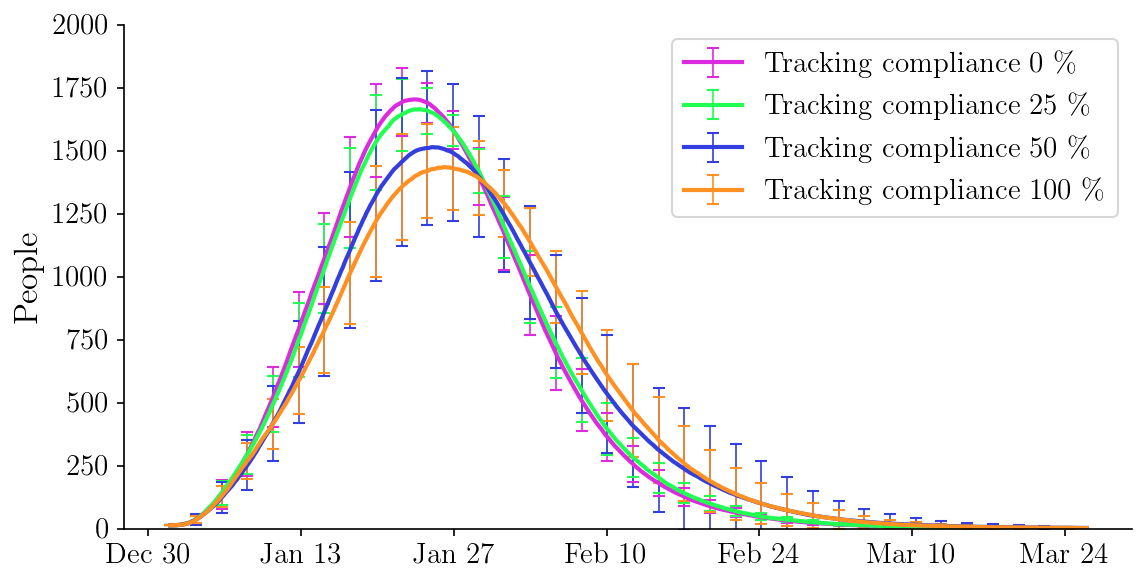

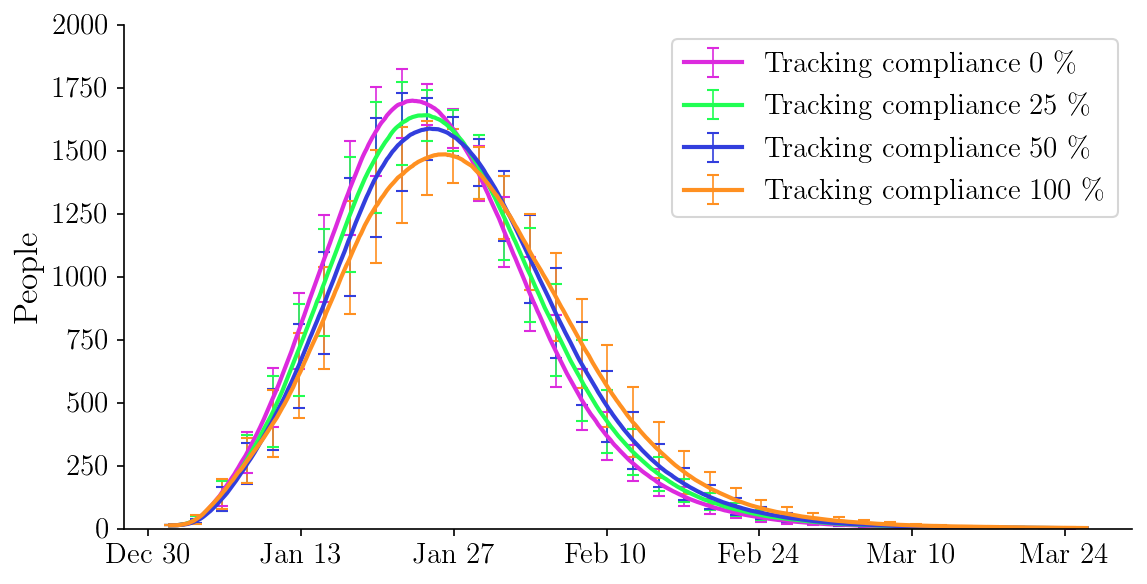

In [6]:
p_compliance = [0.0, 0.25, 0.5, 1.0]
c = 0 # seed
runstr = f'run{c}_'
FIGSIZE = (8, 4)

plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['basic', 'advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=2000, errorevery=14)
   

In [ ]:
plt.close()

## 4.4 Testing and Tracing

### 4.4.1. Effects of smart testing strategies using contact tracing

In [ ]:
testing_params_TT_0 = standard_testing(max_time_future)
testing_params_TT_0['test_smart_delta'] = 24.0 * 3 # time window considered for inspecting contacts
testing_params_TT_0['test_smart_action'] = 'test'
testing_params_TT_0['test_targets'] = 'isym'

contacts_inspected = [10, 25] # how many contacts are inspected in the `test_smart_delta` window
duration_weeks_TT_0 = 12 # strategies tested for 6 weeks starting today

summaries_TT_0 = dict()

In [ ]:
# baseline taken from above
for contacts in contacts_inspected:
    summaries_TT_0[contacts] = [future_baseline]

# Testing strategies
for contacts in contacts_inspected:
    for policy in ['basic', 'advanced']:
        testing_params_TT_0['smart_tracing'] = policy
        testing_params_TT_0['test_smart_num_contacts'] = contacts
        m = []
        res = run(testing_params_TT_0, m, max_time_future, present_seeds) 
        summaries_TT_0[contacts].append(res)

        print(contacts, policy, ' done.')


In [ ]:
save_summary(summaries_TT_0, 'summaries_TT_0.pk')
summaries_TT_0 = load_summary('summaries_TT_0.pk')

In [ ]:
plotter = Plotter()
for j, contacts in enumerate(contacts_inspected):
    summaries_ = summaries_TT_0[contacts]
    titles_TT_0_ = ['No contact tracing', 'Basic contact tracing', 'Advanced contact tracing']
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_TT_0_, 
        figtitle=(f'Tracing strategies when testing {contacts} contacts'),
        filename=runstr + f'TT_00{j}', 
        show_positives=True,
        figsize=FIGSIZE, acc=500, 
        ymax=200, errorevery=14)
    
    for l, titl in enumerate(titles_TT_0_):
        plotter.plot_daily_tested(summaries_[l], 
            title='Test results for ' + titl, 
            filename=runstr + f'TT_1{j}{k}', 
            figsize=FIGSIZE, errorevery=14, acc=500, ymax=200)
